### __Method 1__

From Binance

In [2]:
import requests
import json
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
def get_historical_klines(symbol, interval, start_time, end_time):
    """
    Fetch historical Kline (candlestick) data from the Binance API.
    
    Args:a
    - symbol (str): Trading pair symbol (e.g., 'BTCUSDT').
    - interval (str): Time interval for each candlestick (e.g., '1h').
    - start_time (int): Start time in milliseconds since the epoch.
    - end_time (int): End time in milliseconds since the epoch.
    
    Returns:
    - List of Kline data.
    """
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": symbol,
        "interval": interval,
        "startTime": start_time,
        "endTime": end_time,
        "limit": 1000  # Max limit per request
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise an error for bad responses
    return response.json()

def fetch_last_5_years_data(symbol, interval="1h", start_time=None, end_time=None):
    """
    Fetch hourly Kline data for the last 5 years.
    
    Args:
    - symbol (str): Trading pair symbol (e.g., 'BTCUSDT').
    
    Returns:
    - DataFrame with Kline data.
    """
    # Calculate the time range
    if end_time is None:
        end_time = int(datetime.now().timestamp() * 1000)  # Current time in milliseconds
    if start_time is None:
        start_time = int((datetime.now() - timedelta(days=5*365)).timestamp() * 1000)  # 5 years ago

    all_klines = []
    
    while start_time < end_time:
        klines = get_historical_klines(symbol, interval, start_time, end_time)
        if not klines:
            break  # Stop if no more data is returned

        all_klines.extend(klines)
        start_time = klines[-1][6] + 1  # Update start time to the next hour after the last kline

    # Process Kline data into a DataFrame
    df = pd.DataFrame(all_klines, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume", 
        "Close Time", "Quote Asset Volume", "Number of Trades", 
        "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", 
        "Ignore"
    ])
    
    # Convert timestamp to datetime
    df["Open Time"] = pd.to_datetime(df["Open Time"], unit='ms')
    df["Close Time"] = pd.to_datetime(df["Close Time"], unit='ms')
    
    # Convert price and volume columns to numeric
    price_columns = ["Open", "High", "Low", "Close", "Volume", "Quote Asset Volume", 
                     "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume"]
    df[price_columns] = df[price_columns].apply(pd.to_numeric, errors='coerce')
    
    return df

# Example usage
symbol = "BTCUSDT"
df_klines = fetch_last_5_years_data(symbol)
pd.DataFrame(df_klines)
df_klines

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
0,2019-11-18 07:00:00,8444.78,8467.78,8423.44,8452.03,1179.405964,2019-11-18 07:59:59.999,9.961595e+06,9639,489.657055,4.136065e+06,0
1,2019-11-18 08:00:00,8451.23,8499.00,8435.23,8473.50,1523.580123,2019-11-18 08:59:59.999,1.289949e+07,13137,774.611366,6.559740e+06,0
2,2019-11-18 09:00:00,8473.54,8480.48,8457.64,8479.21,1094.455586,2019-11-18 09:59:59.999,9.266703e+06,8443,669.960287,5.672482e+06,0
3,2019-11-18 10:00:00,8479.38,8479.74,8454.29,8458.26,932.478652,2019-11-18 10:59:59.999,7.891245e+06,8733,500.645506,4.236799e+06,0
4,2019-11-18 11:00:00,8458.53,8466.19,8425.00,8443.77,1339.452976,2019-11-18 11:59:59.999,1.131181e+07,13749,651.997776,5.506608e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43761,2024-11-16 02:00:00,91249.30,91709.06,91151.51,91405.54,1116.540260,2024-11-16 02:59:59.999,1.021367e+08,220081,569.245740,5.206862e+07,0
43762,2024-11-16 03:00:00,91405.54,91597.08,91053.48,91252.03,882.780640,2024-11-16 03:59:59.999,8.060436e+07,208407,450.129500,4.110442e+07,0
43763,2024-11-16 04:00:00,91252.04,91400.00,91064.24,91269.69,674.331010,2024-11-16 04:59:59.999,6.149287e+07,170902,304.972510,2.781061e+07,0
43764,2024-11-16 05:00:00,91269.70,91779.66,91144.74,91350.34,837.022670,2024-11-16 05:59:59.999,7.656061e+07,183130,488.064350,4.464423e+07,0


From Bybit

In [4]:
import requests
import pandas as pd
from datetime import datetime

def fetch_bybit_klines(symbol, interval, limit=200, start_time=None, end_time=None):
    url = "https://api.bybit.com/v5/market/kline"
    params = {
        "symbol": symbol,         # Example: 'BTCUSDT'
        "category": "linear",     # Could be 'linear' or 'inverse'
        "interval": interval,     # '1', '3', '5', '15', '30', '60', 'D'
        "limit": limit,           # Maximum of 200
    }
    
    if start_time:
        params['start'] = start_time
    if end_time:
        params['end'] = end_time

    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

def process_klines_to_dataframe(klines):
    # Verify the structure of the data
    if 'result' not in klines or 'list' not in klines['result']:
        print("Unexpected data structure:", klines)
        return None
    
    # Extract OHLCV values along with timestamps
    ohlcv_data = []
    timestamps = []
    
    for kline in klines['result']['list']:  # Access the 'list' key where the OHLCV data resides
        # Check if kline has the correct length to avoid index errors
        if len(kline) < 6:
            print(f"Unexpected Kline format: {kline}")
            continue
        
        # Convert timestamp to a readable format
        time = datetime.utcfromtimestamp(int(kline[0]) / 1000)  # Convert from milliseconds to seconds
        
        # Add time to the list of timestamps
        timestamps.append(time)
        
        # Extract OHLCV: open, high, low, close, volume
        ohlcv_data.append([
            float(kline[1]),  # Open price
            float(kline[2]),  # High price
            float(kline[3]),  # Low price
            float(kline[4]),  # Close price
            float(kline[5])   # Volume
        ])

    if not ohlcv_data:
        print("No valid OHLCV data found.")
        return None

    # Create a DataFrame with OHLCV columns and use timestamps as the index
    df = pd.DataFrame(ohlcv_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'], index=timestamps)
    
    # Set the index name to "Time"
    df.index.name = 'Time'
    
    return df

# Example usage
symbol = "BTCUSDT"
interval = "60"  # '60' for hourly candles
klines = fetch_bybit_klines(symbol, interval, limit=100)

if klines:
    df_ohlcv = process_klines_to_dataframe(klines)
pd.DataFrame(df_ohlcv)

C:\Users\yassi\AppData\Local\Temp\ipykernel_49800\1207104426.py:44: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  time = datetime.utcfromtimestamp(int(kline[0]) / 1000)  # Convert from milliseconds to seconds


,Open,High,Low,Close,Volume
Time,,,,,
2024-11-16 06:00:00,91413.9,91430.5,91287.1,91312.2,198.833
2024-11-16 05:00:00,91363.9,91856.3,91230.3,91413.9,2000.850
2024-11-16 04:00:00,91321.3,91477.2,91123.0,91363.9,1144.131
2024-11-16 03:00:00,91491.7,91677.6,91075.0,91321.3,2158.413
2024-11-16 02:00:00,91306.7,91796.9,91213.4,91491.7,2555.675
...,...,...,...,...,...
2024-11-12 07:00:00,89653.5,90077.0,89060.2,89095.3,11214.223
2024-11-12 06:00:00,88482.4,89979.5,88268.1,89653.5,11322.657
2024-11-12 05:00:00,88525.1,88904.9,88240.8,88482.4,5591.376


### __Method 2__

From Binance

In [5]:
def get_binance_klines(symbol, interval, start_time, end_time, limit=1000):
    url = "https://api.binance.com/api/v3/klines"  # We added the endpoint to the URL so we can retrieve the klines data

    start_time_ms = int(start_time.timestamp() * 1000)  # The binance api uses milliseconds, so we need to convert the date to milliseconds
    end_time_ms = int(end_time.timestamp() * 1000)  # We have to do the same for the end time as well

    # Get a list of the dates between the two given dates
    date_list = pd.date_range(start=start_time, end=end_time, freq='D').tolist()

    all_df = pd.DataFrame()  # We will store all the dataframes in this dataframe

    for i in range(len(date_list) - 1):
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': int(date_list[i].timestamp() * 1000),
            'endTime': int((date_list[i + 1] - dt.timedelta(seconds=1)).timestamp() * 1000),
            'limit': limit
        }
        response = requests.get(url, params=params)
        data = response.json()
        if not data:
            continue
        df = pd.DataFrame(data)
        all_df = pd.concat([all_df, df], ignore_index=True)

    if all_df.empty:
        return None

    # Adding names to the columns
    all_df = all_df.iloc[:, 0:6]  # We only need the first 6 columns
    all_df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']  # Assigning names to the columns

    all_df.index = [dt.datetime.fromtimestamp(x / 1000.0) for x in all_df['Open Time']]

    all_df.drop('Open Time', axis=1, inplace=True)  # We don't need the open time column anymore

    return all_df
    

In [6]:
get_binance_klines(symbol='BTCUSDT', interval='1h', start_time=dt.datetime(2021, 1, 1), end_time=dt.datetime(2021, 1, 10))

,Open,High,Low,Close,Volume
2020-12-31 19:00:00,28923.63000000,29031.34000000,28690.17000000,28995.13000000,2311.81144500
2020-12-31 20:00:00,28995.13000000,29470.00000000,28960.35000000,29409.99000000,5403.06847100
2020-12-31 21:00:00,29410.00000000,29465.26000000,29120.03000000,29194.65000000,2384.23156000
2020-12-31 22:00:00,29195.25000000,29367.00000000,29150.02000000,29278.40000000,1461.34507700
2020-12-31 23:00:00,29278.41000000,29395.00000000,29029.40000000,29220.31000000,2038.04680300
...,...,...,...,...,...
2021-01-09 14:00:00,40650.00000000,40880.00000000,40469.40000000,40665.91000000,1864.14249300
2021-01-09 15:00:00,40665.91000000,40781.69000000,40050.00000000,40606.22000000,3330.65176500
2021-01-09 16:00:00,40610.35000000,40755.00000000,40483.17000000,40718.80000000,2433.80943000
2021-01-09 17:00:00,40718.81000000,40743.47000000,40120.00000000,40281.09000000,1973.25228700


In [ ]:
def get_binance_klines(symbols, interval, start_time, end_time, limit=1000):
    """
    Takes start_time and end_time as datetime objects
    """


    url = "https://api.binance.com/api/v3/klines"  # We added the endpoint to the URL so we can retrieve the klines data

    # Get a list of the dates between the two given dates
    date_list = pd.date_range(start=start_time, end=end_time, freq='D').tolist()

    data_frames = {}  # Dictionary to store dataframes for each symbol

    for symbol in symbols:
        all_df = pd.DataFrame()  # We will store all the dataframes in this dataframe

        for i in range(len(date_list) - 1):
            params = {
                'symbol': symbol,
                'interval': interval,
                'startTime': int(date_list[i].timestamp() * 1000),
                'endTime': int((date_list[i + 1] - dt.timedelta(seconds=1)).timestamp() * 1000),
                'limit': limit
            }
            response = requests.get(url, params=params)
            data = response.json()
            if not data:
                continue
            df = pd.DataFrame(data)
            all_df = pd.concat([all_df, df], ignore_index=True)

        if not all_df.empty:
            # Adding names to the columns
            all_df = all_df.iloc[:, 0:6]  # We only need the first 6 columns
            all_df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']  # Assigning names to the columns

            all_df.index = [dt.datetime.fromtimestamp(x / 1000.0) for x in all_df['Open Time']]

            all_df.drop('Open Time', axis=1, inplace=True)  # We don't need the open time column anymore

            data_frames[symbol] = all_df

    if not data_frames:
        return None

    # Concatenate all DataFrames and create a hierarchical index
    combined_df = pd.concat(data_frames, axis=1)
    combined_df = combined_df.swaplevel(axis=1).sort_index(axis=1)

    return combined_df

In [8]:
# Example usage
symbols = ['BTCUSDT', 'ETHUSDT']
interval = '1h'
start_time = dt.datetime(2021, 1, 1)
end_time = dt.datetime(2021, 1, 10)

combined_df = get_binance_klines(symbols, interval, start_time, end_time)
combined_df

Close                           High  \
                            BTCUSDT        ETHUSDT         BTCUSDT   
2020-12-31 19:00:00  28995.13000000   734.07000000  29031.34000000   
2020-12-31 20:00:00  29409.99000000   748.28000000  29470.00000000   
2020-12-31 21:00:00  29194.65000000   744.06000000  29465.26000000   
2020-12-31 22:00:00  29278.40000000   744.82000000  29367.00000000   
2020-12-31 23:00:00  29220.31000000   742.29000000  29395.00000000   
...                             ...            ...             ...   
2021-01-09 14:00:00  40665.91000000  1229.42000000  40880.00000000   
2021-01-09 15:00:00  40606.22000000  1271.14000000  40781.69000000   
2021-01-09 16:00:00  40718.80000000  1287.96000000  40755.00000000   
2021-01-09 17:00:00  40281.09000000  1286.61000000  40743.47000000   
2021-01-09 18:00:00  40088.22000000  1276.00000000  40415.01000000   

                                               Low                 \
                           ETHUSDT         BTCUSDT        ETHUSDT   
2020-12-31 19:00:00   739.00000000  28690.17000000   729.33000000   
2020-12-31 20:00:00   749.00000000  28960.35000000   733.37000000   
2020-12-31 21:00:00   749.00000000  29120.03000000   742.27000000   
2020-12-31 22:00:00   747.23000000  29150.02000000   743.10000000   
2020-12-31 23:00:00   747.09000000  29029.40000000   739.30000000   
...                            ...             ...            ...   
2021-01-09 14:00:00  1235.69000000  40469.40000000  1220.48000000   
2021-01-09 15:00:00  1272.00000000  40050.00000000  1217.54000000   
2021-01-09 16:00:00  1294.18000000  40483.17000000  1261.50000000   
2021-01-09 17:00:00  1304.37000000  40120.00000000  1276.32000000   
2021-01-09 18:00:00  1292.74000000  39928.91000000  1266.85000000   

                               Open                        Volume  \
                            BTCUSDT        ETHUSDT        BTCUSDT   
2020-12-31 19:00:00  28923.63000000   736.42000000  2311.81144500   
2020-12-31 20:00:00  28995.13000000   734.08000000  5403.06847100   
2020-12-31 21:00:00  29410.00000000   748.27000000  2384.23156000   
2020-12-31 22:00:00  29195.25000000   744.06000000  1461.34507700   
2020-12-31 23:00:00  29278.41000000   744.87000000  2038.04680300   
...                             ...            ...            ...   
2021-01-09 14:00:00  40650.00000000  1224.69000000  1864.14249300   
2021-01-09 15:00:00  40665.91000000  1229.33000000  3330.65176500   
2021-01-09 16:00:00  40610.35000000  1271.14000000  2433.80943000   
2021-01-09 17:00:00  40718.81000000  1287.95000000  1973.25228700   
2021-01-09 18:00:00  40283.73000000  1286.65000000  3255.53576100   

                                      
                             ETHUSDT  
2020-12-31 19:00:00   27932.69884000  
2020-12-31 20:00:00   52336.18779000  
2020-12-31 21:00:00   33019.50100000  
2020-12-31 22:00:00   17604.80859000  
2020-12-31 23:00:00   18794.15424000  
...                              ...  
2021-01-09 14:00:00   36022.81451000  
2021-01-09 15:00:00  116955.13239000  
2021-01-09 16:00:00  139273.22601000  
2021-01-09 17:00:00   84360.71587000  
2021-01-09 18:00:00   64558.95579000  

[216 rows x 10 columns]

In [9]:
combined_df = combined_df.apply(pd.to_numeric, errors='coerce')
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2020-12-31 19:00:00 to 2021-01-09 18:00:00
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTCUSDT)   216 non-null    float64
 1   (Close, ETHUSDT)   216 non-null    float64
 2   (High, BTCUSDT)    216 non-null    float64
 3   (High, ETHUSDT)    216 non-null    float64
 4   (Low, BTCUSDT)     216 non-null    float64
 5   (Low, ETHUSDT)     216 non-null    float64
 6   (Open, BTCUSDT)    216 non-null    float64
 7   (Open, ETHUSDT)    216 non-null    float64
 8   (Volume, BTCUSDT)  216 non-null    float64
 9   (Volume, ETHUSDT)  216 non-null    float64
dtypes: float64(10)
memory usage: 18.6 KB


<Axes: >

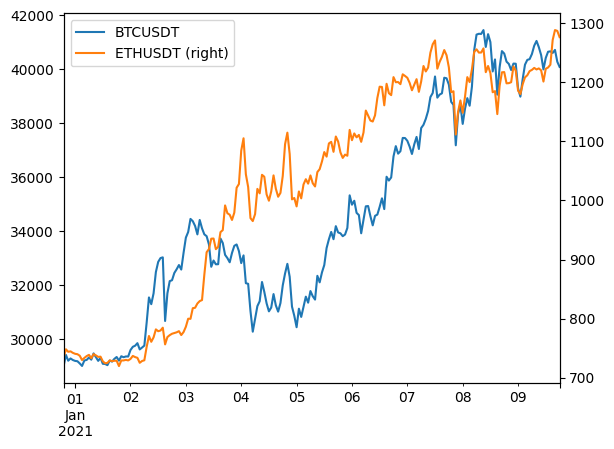

In [10]:
combined_df['Close'].plot(secondary_y='ETHUSDT') #Now we are able to plot the values 

Preparing Data for analysis

In [11]:
import numpy as np

for col in combined_df['Close'].columns:
    combined_df['Returns', col] = combined_df['Close', col].pct_change()
    combined_df['Log Returns', col] = np.log(1 + combined_df['Returns', col])
    combined_df["Creturns", col] = combined_df["Returns", col].cumsum().apply(np.exp)

# Sort the columns index
combined_df = combined_df.sort_index(axis=1)

In [12]:
combined_df

Close           Creturns                High           \
                      BTCUSDT  ETHUSDT   BTCUSDT   ETHUSDT   BTCUSDT  ETHUSDT   
2020-12-31 19:00:00  28995.13   734.07       NaN       NaN  29031.34   739.00   
2020-12-31 20:00:00  29409.99   748.28  1.014411  1.019546  29470.00   749.00   
2020-12-31 21:00:00  29194.65   744.06  1.007010  1.013813  29465.26   749.00   
2020-12-31 22:00:00  29278.40   744.82  1.009903  1.014849  29367.00   747.23   
2020-12-31 23:00:00  29220.31   742.29  1.007902  1.011407  29395.00   747.09   
...                       ...      ...       ...       ...       ...      ...   
2021-01-09 14:00:00  40665.91  1229.42  1.431809  1.738416  40880.00  1235.69   
2021-01-09 15:00:00  40606.22  1271.14  1.429709  1.798421  40781.69  1272.00   
2021-01-09 16:00:00  40718.80  1287.96  1.433679  1.822377  40755.00  1294.18   
2021-01-09 17:00:00  40281.09  1286.61  1.418350  1.820468  40743.47  1304.37   
2021-01-09 18:00:00  40088.22  1276.00  1.411575  1.805517  40415.01  1292.74   

                    Log Returns                 Low               Open  \
                        BTCUSDT   ETHUSDT   BTCUSDT  ETHUSDT   BTCUSDT   
2020-12-31 19:00:00         NaN       NaN  28690.17   729.33  28923.63   
2020-12-31 20:00:00    0.014207  0.019173  28960.35   733.37  28995.13   
2020-12-31 21:00:00   -0.007349 -0.005656  29120.03   742.27  29410.00   
2020-12-31 22:00:00    0.002865  0.001021  29150.02   743.10  29195.25   
2020-12-31 23:00:00   -0.001986 -0.003403  29029.40   739.30  29278.41   
...                         ...       ...       ...      ...       ...   
2021-01-09 14:00:00    0.000391  0.003855  40469.40  1220.48  40650.00   
2021-01-09 15:00:00   -0.001469  0.033372  40050.00  1217.54  40665.91   
2021-01-09 16:00:00    0.002769  0.013145  40483.17  1261.50  40610.35   
2021-01-09 17:00:00   -0.010808 -0.001049  40120.00  1276.32  40718.81   
2021-01-09 18:00:00   -0.004800 -0.008281  39928.91  1266.85  40283.73   

                               Returns                 Volume                
                     ETHUSDT   BTCUSDT   ETHUSDT      BTCUSDT       ETHUSDT  
2020-12-31 19:00:00   736.42       NaN       NaN  2311.811445   27932.69884  
2020-12-31 20:00:00   734.08  0.014308  0.019358  5403.068471   52336.18779  
2020-12-31 21:00:00   748.27 -0.007322 -0.005640  2384.231560   33019.50100  
2020-12-31 22:00:00   744.06  0.002869  0.001021  1461.345077   17604.80859  
2020-12-31 23:00:00   744.87 -0.001984 -0.003397  2038.046803   18794.15424  
...                      ...       ...       ...          ...           ...  
2021-01-09 14:00:00  1224.69  0.000391  0.003862  1864.142493   36022.81451  
2021-01-09 15:00:00  1229.33 -0.001468  0.033935  3330.651765  116955.13239  
2021-01-09 16:00:00  1271.14  0.002772  0.013232  2433.809430  139273.22601  
2021-01-09 17:00:00  1287.95 -0.010750 -0.001048  1973.252287   84360.71587  
2021-01-09 18:00:00  1286.65 -0.004788 -0.008246  3255.535761   64558.95579  

[216 rows x 16 columns]

In [13]:
combined_df = combined_df.stack(level=1, future_stack= True) #We are stacking the columns to create a multi-index dataframe


In [14]:
combined_df

Close  Creturns      High  Log Returns  \
2020-12-31 19:00:00 BTCUSDT  28995.13       NaN  29031.34          NaN   
                    ETHUSDT    734.07       NaN    739.00          NaN   
2020-12-31 20:00:00 BTCUSDT  29409.99  1.014411  29470.00     0.014207   
                    ETHUSDT    748.28  1.019546    749.00     0.019173   
2020-12-31 21:00:00 BTCUSDT  29194.65  1.007010  29465.26    -0.007349   
...                               ...       ...       ...          ...   
2021-01-09 16:00:00 ETHUSDT   1287.96  1.822377   1294.18     0.013145   
2021-01-09 17:00:00 BTCUSDT  40281.09  1.418350  40743.47    -0.010808   
                    ETHUSDT   1286.61  1.820468   1304.37    -0.001049   
2021-01-09 18:00:00 BTCUSDT  40088.22  1.411575  40415.01    -0.004800   
                    ETHUSDT   1276.00  1.805517   1292.74    -0.008281   

                                  Low      Open   Returns         Volume  
2020-12-31 19:00:00 BTCUSDT  28690.17  28923.63       NaN    2311.811445  
                    ETHUSDT    729.33    736.42       NaN   27932.698840  
2020-12-31 20:00:00 BTCUSDT  28960.35  28995.13  0.014308    5403.068471  
                    ETHUSDT    733.37    734.08  0.019358   52336.187790  
2020-12-31 21:00:00 BTCUSDT  29120.03  29410.00 -0.007322    2384.231560  
...                               ...       ...       ...            ...  
2021-01-09 16:00:00 ETHUSDT   1261.50   1271.14  0.013232  139273.226010  
2021-01-09 17:00:00 BTCUSDT  40120.00  40718.81 -0.010750    1973.252287  
                    ETHUSDT   1276.32   1287.95 -0.001048   84360.715870  
2021-01-09 18:00:00 BTCUSDT  39928.91  40283.73 -0.004788    3255.535761  
                    ETHUSDT   1266.85   1286.65 -0.008246   64558.955790  

[432 rows x 8 columns]

In [21]:
#Note that even though we have a multi-index dataframe, we still need to use the unstacked format to add new columns,
#otherwise the calculations will get mixed up between the different symbols
combined_df = combined_df.unstack()

for col in combined_df['Close'].columns:
    combined_df['Returns', col] = combined_df['Close', col].pct_change()
    combined_df['Log Returns', col] = np.log(1 + combined_df['Returns', col])
    combined_df["Creturns", col] = combined_df["Returns", col].cumsum().apply(np.exp)

combined_df

Close           Creturns                High           \
                      BTCUSDT  ETHUSDT   BTCUSDT   ETHUSDT   BTCUSDT  ETHUSDT   
2020-12-31 19:00:00  28995.13   734.07       NaN       NaN  29031.34   739.00   
2020-12-31 20:00:00  29409.99   748.28  1.014411  1.019546  29470.00   749.00   
2020-12-31 21:00:00  29194.65   744.06  1.007010  1.013813  29465.26   749.00   
2020-12-31 22:00:00  29278.40   744.82  1.009903  1.014849  29367.00   747.23   
2020-12-31 23:00:00  29220.31   742.29  1.007902  1.011407  29395.00   747.09   
...                       ...      ...       ...       ...       ...      ...   
2021-01-09 14:00:00  40665.91  1229.42  1.431809  1.738416  40880.00  1235.69   
2021-01-09 15:00:00  40606.22  1271.14  1.429709  1.798421  40781.69  1272.00   
2021-01-09 16:00:00  40718.80  1287.96  1.433679  1.822377  40755.00  1294.18   
2021-01-09 17:00:00  40281.09  1286.61  1.418350  1.820468  40743.47  1304.37   
2021-01-09 18:00:00  40088.22  1276.00  1.411575  1.805517  40415.01  1292.74   

                    Log Returns                 Low               Open  \
                        BTCUSDT   ETHUSDT   BTCUSDT  ETHUSDT   BTCUSDT   
2020-12-31 19:00:00         NaN       NaN  28690.17   729.33  28923.63   
2020-12-31 20:00:00    0.014207  0.019173  28960.35   733.37  28995.13   
2020-12-31 21:00:00   -0.007349 -0.005656  29120.03   742.27  29410.00   
2020-12-31 22:00:00    0.002865  0.001021  29150.02   743.10  29195.25   
2020-12-31 23:00:00   -0.001986 -0.003403  29029.40   739.30  29278.41   
...                         ...       ...       ...      ...       ...   
2021-01-09 14:00:00    0.000391  0.003855  40469.40  1220.48  40650.00   
2021-01-09 15:00:00   -0.001469  0.033372  40050.00  1217.54  40665.91   
2021-01-09 16:00:00    0.002769  0.013145  40483.17  1261.50  40610.35   
2021-01-09 17:00:00   -0.010808 -0.001049  40120.00  1276.32  40718.81   
2021-01-09 18:00:00   -0.004800 -0.008281  39928.91  1266.85  40283.73   

                               Returns                 Volume                \
                     ETHUSDT   BTCUSDT   ETHUSDT      BTCUSDT       ETHUSDT   
2020-12-31 19:00:00   736.42       NaN       NaN  2311.811445   27932.69884   
2020-12-31 20:00:00   734.08  0.014308  0.019358  5403.068471   52336.18779   
2020-12-31 21:00:00   748.27 -0.007322 -0.005640  2384.231560   33019.50100   
2020-12-31 22:00:00   744.06  0.002869  0.001021  1461.345077   17604.80859   
2020-12-31 23:00:00   744.87 -0.001984 -0.003397  2038.046803   18794.15424   
...                      ...       ...       ...          ...           ...   
2021-01-09 14:00:00  1224.69  0.000391  0.003862  1864.142493   36022.81451   
2021-01-09 15:00:00  1229.33 -0.001468  0.033935  3330.651765  116955.13239   
2021-01-09 16:00:00  1271.14  0.002772  0.013232  2433.809430  139273.22601   
2021-01-09 17:00:00  1287.95 -0.010750 -0.001048  1973.252287   84360.71587   
2021-01-09 18:00:00  1286.65 -0.004788 -0.008246  3255.535761   64558.95579   

                    Volume in Dollars                
                              BTCUSDT       ETHUSDT  
2020-12-31 19:00:00      6.703127e+07  2.050456e+07  
2020-12-31 20:00:00      1.589042e+08  3.916212e+07  
2020-12-31 21:00:00      6.960681e+07  2.456849e+07  
2020-12-31 22:00:00      4.278585e+07  1.311241e+07  
2020-12-31 23:00:00      5.955236e+07  1.395071e+07  
...                               ...           ...  
2021-01-09 14:00:00      7.580705e+07  4.428717e+07  
2021-01-09 15:00:00      1.352452e+08  1.486663e+08  
2021-01-09 16:00:00      9.910180e+07  1.793783e+08  
2021-01-09 17:00:00      7.948475e+07  1.085393e+08  
2021-01-09 18:00:00      1.305086e+08  8.237723e+07  

[216 rows x 18 columns]

<Axes: >

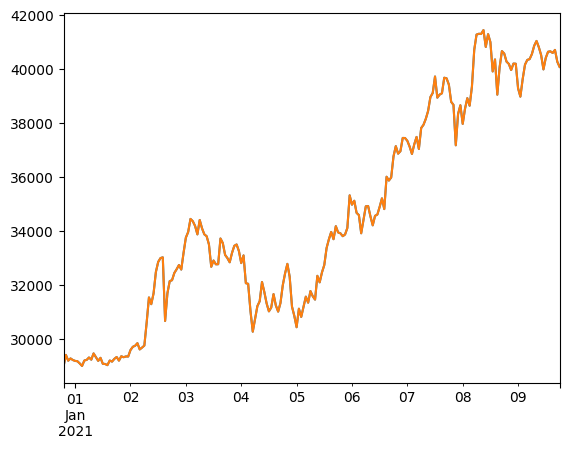

In [16]:
#However if we want to perform an action on a single column (like plotting the prices of one column) it is better to either:
#1. Unstack the dataframe
combined_df.unstack()['Close']['BTCUSDT'].plot() #This will plot the closing prices of BTCUSDT

#2. Use the xs method
combined_df.xs('BTCUSDT', level=1)['Close'].plot() #This will also plot the closing prices of BTCUSDT

#The first method is more readable and easier to understand, but the second method is more efficient and faster

Calculating Volume

In [17]:
def calculate_volume_in_dollars(df):
    df['Volume in Dollars'] = df['Volume'] * df['Close']
    return df

combined_df = calculate_volume_in_dollars(combined_df)
combined_df

Close  Creturns      High  Log Returns  \
2020-12-31 19:00:00 BTCUSDT  28995.13       NaN  29031.34          NaN   
                    ETHUSDT    734.07       NaN    739.00          NaN   
2020-12-31 20:00:00 BTCUSDT  29409.99  1.014411  29470.00     0.014207   
                    ETHUSDT    748.28  1.019546    749.00     0.019173   
2020-12-31 21:00:00 BTCUSDT  29194.65  1.007010  29465.26    -0.007349   
...                               ...       ...       ...          ...   
2021-01-09 16:00:00 ETHUSDT   1287.96  1.822377   1294.18     0.013145   
2021-01-09 17:00:00 BTCUSDT  40281.09  1.418350  40743.47    -0.010808   
                    ETHUSDT   1286.61  1.820468   1304.37    -0.001049   
2021-01-09 18:00:00 BTCUSDT  40088.22  1.411575  40415.01    -0.004800   
                    ETHUSDT   1276.00  1.805517   1292.74    -0.008281   

                                  Low      Open   Returns         Volume  \
2020-12-31 19:00:00 BTCUSDT  28690.17  28923.63       NaN    2311.811445   
                    ETHUSDT    729.33    736.42       NaN   27932.698840   
2020-12-31 20:00:00 BTCUSDT  28960.35  28995.13  0.014308    5403.068471   
                    ETHUSDT    733.37    734.08  0.019358   52336.187790   
2020-12-31 21:00:00 BTCUSDT  29120.03  29410.00 -0.007322    2384.231560   
...                               ...       ...       ...            ...   
2021-01-09 16:00:00 ETHUSDT   1261.50   1271.14  0.013232  139273.226010   
2021-01-09 17:00:00 BTCUSDT  40120.00  40718.81 -0.010750    1973.252287   
                    ETHUSDT   1276.32   1287.95 -0.001048   84360.715870   
2021-01-09 18:00:00 BTCUSDT  39928.91  40283.73 -0.004788    3255.535761   
                    ETHUSDT   1266.85   1286.65 -0.008246   64558.955790   

                             Volume in Dollars  
2020-12-31 19:00:00 BTCUSDT       6.703127e+07  
                    ETHUSDT       2.050456e+07  
2020-12-31 20:00:00 BTCUSDT       1.589042e+08  
                    ETHUSDT       3.916212e+07  
2020-12-31 21:00:00 BTCUSDT       6.960681e+07  
...                                        ...  
2021-01-09 16:00:00 ETHUSDT       1.793783e+08  
2021-01-09 17:00:00 BTCUSDT       7.948475e+07  
                    ETHUSDT       1.085393e+08  
2021-01-09 18:00:00 BTCUSDT       1.305086e+08  
                    ETHUSDT       8.237723e+07  

[432 rows x 9 columns]

Market Cap

In [18]:
import requests
import pandas as pd
from datetime import datetime

# Function to fetch historical supply data for a given coin
def get_historical_supply(coin_id, start_date, end_date):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range'
    
    # Convert dates to Unix timestamps
    start_timestamp = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp())
    end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp())
    
    # Request parameters
    params = {
        'vs_currency': 'usd',
        'from': start_timestamp,
        'to': end_timestamp
    }

    # Fetch data from CoinGecko API
    response = requests.get(url, params=params)
    data = response.json()

    # Extract the circulating supply data
    circulating_supply_data = data['market_caps']  # market_caps contain timestamps, prices, and circulating supply
    
    # Convert data to a pandas DataFrame for easy manipulation
    df = pd.DataFrame(circulating_supply_data, columns=['timestamp', 'market_cap'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['circulating_supply'] = df['market_cap'] / df['market_cap'].shift(1)  # approximate circulating supply from market cap
    
    return df

# Example usage
coin_id = 'bitcoin'  # Bitcoin's CoinGecko ID
start_date = '2024-01-01'
end_date = '2024-11-01'

df_supply = get_historical_supply(coin_id, start_date, end_date)

df_supply

,timestamp,market_cap,circulating_supply
0,2024-01-02,8.638049e+11,NaN
1,2024-01-03,8.783950e+11,1.016890
2,2024-01-04,8.382084e+11,0.954250
3,2024-01-05,8.663530e+11,1.033577
4,2024-01-06,8.636909e+11,0.996927
...,...,...,...
300,2024-10-28,1.343351e+12,1.013702
301,2024-10-29,1.380875e+12,1.027933
302,2024-10-30,1.439310e+12,1.042318
303,2024-10-31,1.431086e+12,0.994286


This is what I was able to get for now, needs more work to be able to find a way to get free market cap data from another API source, that provides longer periods. \
Another problem is that we only have the tickers, so we need to find a way to convert the each ticker to the name of the coin if the API (like BTCUSDT -> bitcoin). This could be done by getting the 'current' data for each coin then creating another list that contains their full names. 